# FNO Model Testing

This notebook loads a trained FNO model and compares predictions with ground truth.

In [23]:
import torch
from operator_data_pipeline import get_nfv_dataset, preprocess_grids, GridDataset
from torch.utils.data import DataLoader
from numerical_methods.plotter import plot_grid_density

# Device selection: cuda > mps > cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


3it [00:04,  1.55s/it]                       


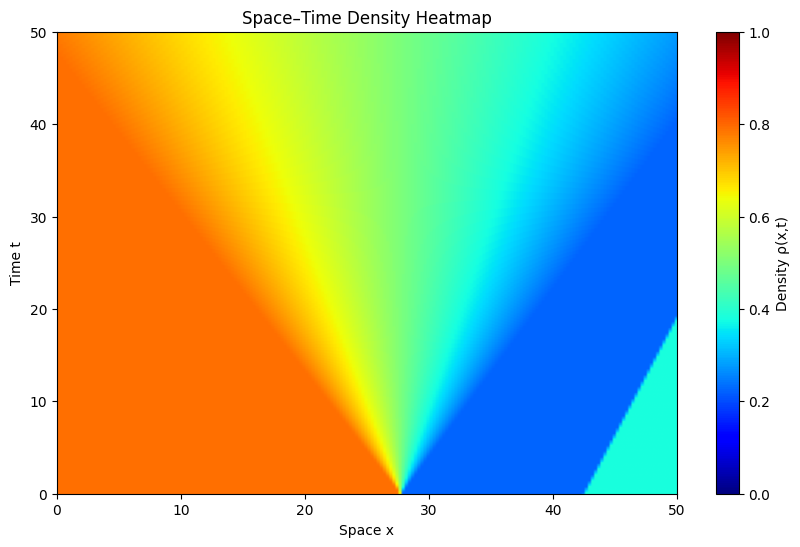

In [32]:
# Grid parameters
from operator_learning.operator_data_pipeline import GridMaskInner


nx = 200
nt = 1000
dx = 0.25
dt = 0.05
max_steps = 3
n_samples = 10

# Generate dataset
grids = get_nfv_dataset(n_samples, nx, nt, dx, dt, max_steps)
dataset = GridDataset(preprocess_grids(grids, nx, nt, dx, dt))
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# Preview a sample grid
plot_grid_density(grids[0], nx, nt, dx, dt)

In [33]:
from model import OperatorModel
from neuralop.models import FNO

# Model configuration - should match training configuration
model = OperatorModel(FNO,
    n_modes=(32, 8),
    hidden_channels=64,
    in_channels=3,
    out_channels=1,
    n_layers=4
)

# Load trained weights
model_path = 'fno.pth'  # Update this path to your trained model
state_dict = torch.load(model_path, weights_only=False, map_location=device)
state_dict = {k: v for k, v in state_dict.items() if k != '_metadata'}
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")

Model loaded from fno.pth


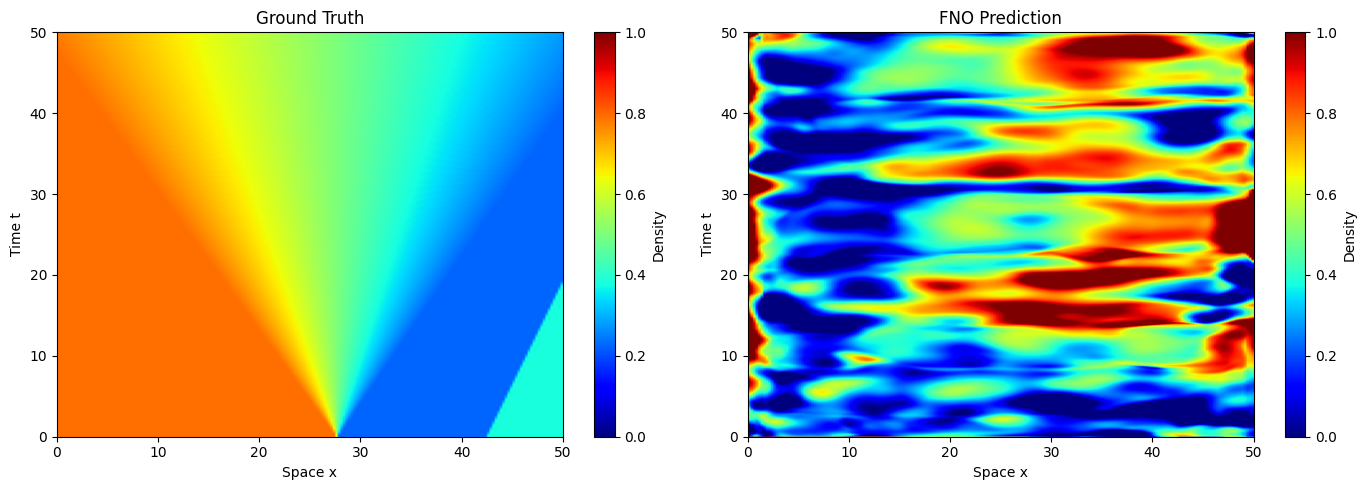

In [34]:
import matplotlib.pyplot as plt

# Get a batch of data
for input_grid, target in dataloader:
    break

# Move data to device
input_grid = input_grid.to(device)
target = target.to(device)

# Run model prediction
with torch.no_grad():
    pred = model(input_grid)

# Select sample index to visualize
idx = 0

# Plot target and prediction side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target
ax = axes[0]
im = ax.imshow(target[idx].squeeze().cpu().numpy(), aspect='auto', origin='lower',
               extent=[0, nx * dx, 0, nt * dt], cmap='jet', vmin=0, vmax=1)
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('Ground Truth')
plt.colorbar(im, ax=ax, label='Density')

# Prediction
ax = axes[1]
im = ax.imshow(pred[idx].squeeze().cpu().numpy(), aspect='auto', origin='lower',
               extent=[0, nx * dx, 0, nt * dt], cmap='jet', vmin=0, vmax=1)
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('FNO Prediction')
plt.colorbar(im, ax=ax, label='Density')

plt.tight_layout()
plt.show()

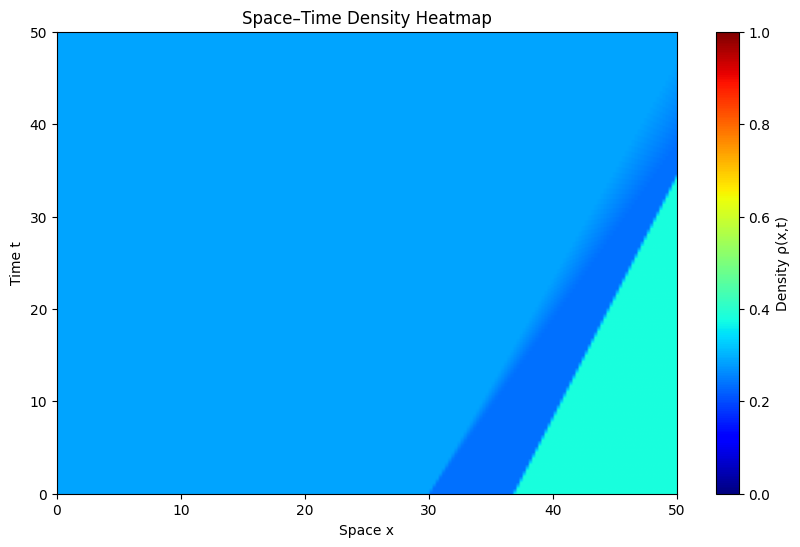

In [35]:
plot_grid_density(target[3, 0].detach().cpu().numpy(), nx, nt, dx, dt)

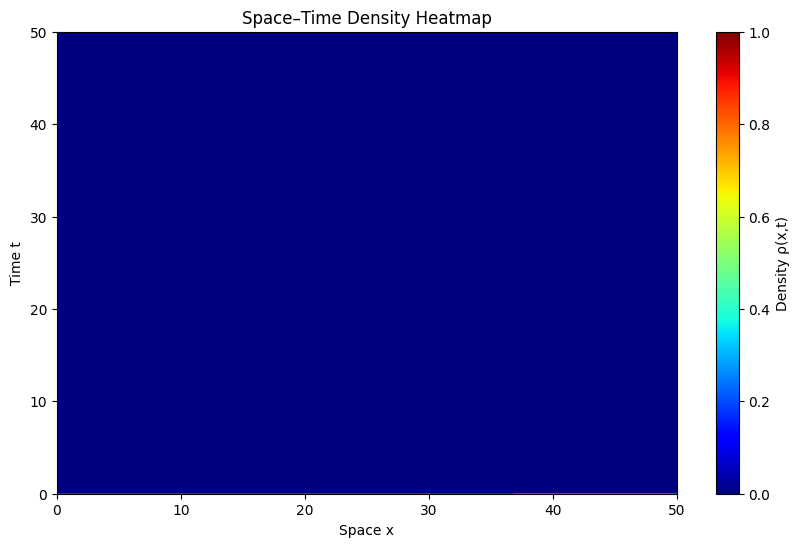

In [36]:
plot_grid_density(input_grid[3, 0].detach().cpu().numpy(), nx, nt, dx, dt)

In [37]:
pred[0, 0, 200]

tensor([1.1685, 1.1284, 1.0798, 0.9419, 0.7876, 0.7145, 0.6573, 0.5739, 0.5211,
        0.4814, 0.4550, 0.4502, 0.4430, 0.4175, 0.3759, 0.3372, 0.3061, 0.2781,
        0.2473, 0.2170, 0.1863, 0.1578, 0.1331, 0.1133, 0.0985, 0.0883, 0.0818,
        0.0775, 0.0733, 0.0688, 0.0681, 0.0849, 0.1267, 0.1902, 0.2645, 0.3393,
        0.4106, 0.4762, 0.5347, 0.5842, 0.6228, 0.6486, 0.6624, 0.6653, 0.6561,
        0.6344, 0.6010, 0.5586, 0.5119, 0.4674, 0.4308, 0.4047, 0.3884, 0.3810,
        0.3809, 0.3838, 0.3852, 0.3849, 0.3836, 0.3812, 0.3778, 0.3735, 0.3684,
        0.3627, 0.3565, 0.3494, 0.3415, 0.3328, 0.3235, 0.3138, 0.3038, 0.2933,
        0.2818, 0.2688, 0.2536, 0.2362, 0.2171, 0.1972, 0.1775, 0.1587, 0.1413,
        0.1258, 0.1132, 0.1037, 0.0972, 0.0935, 0.0923, 0.0937, 0.0977, 0.1039,
        0.1123, 0.1232, 0.1366, 0.1530, 0.1720, 0.1929, 0.2146, 0.2364, 0.2578,
        0.2783, 0.2966, 0.3117, 0.3238, 0.3336, 0.3415, 0.3477, 0.3526, 0.3563,
        0.3591, 0.3612, 0.3625, 0.3626, 

MSE: 0.215650
MAE: 0.392571


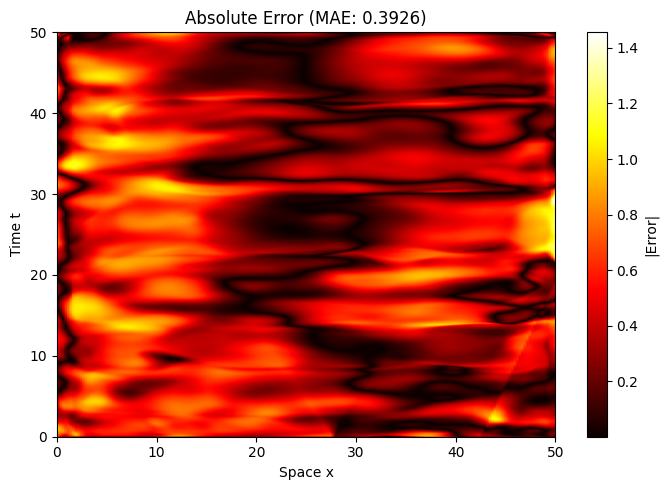

In [38]:
# Compute and display error
error = (pred[idx] - target[idx]).abs()
mse = ((pred[idx] - target[idx]) ** 2).mean().item()
mae = error.mean().item()

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")

# Plot error map
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(error.squeeze().cpu().numpy(), aspect='auto', origin='lower',
               extent=[0, nx * dx, 0, nt * dt], cmap='hot')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title(f'Absolute Error (MAE: {mae:.4f})')
plt.colorbar(im, ax=ax, label='|Error|')
plt.tight_layout()
plt.show()